<a href="https://colab.research.google.com/github/Safa06/Thesis/blob/main/IP(seminar).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
# VGG16
#import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import scipy.io
from scipy.io import loadmat
#from skimage.transform import resize
from keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint

# **Data Load**

In [ ]:
# DATA load
mat_data1= scipy.io.loadmat('Indian_pines_corrected.mat')
mat_data2=scipy.io.loadmat('Indian_pines_gt.mat')
X=mat_data1['indian_pines_corrected']
y=mat_data2['indian_pines_gt']
print(X.shape)
print(y.shape)

(145, 145, 200)
(145, 145)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Apply PCA,PADDING**

In [ ]:
# Apply PCA to minimize band from 200 to 3 band
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

K = 3
X,pca= applyPCA(X,numComponents=K)
print(X.shape, y.shape)



#padding with zero
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


(145, 145, 3) (145, 145)


# **Create Patches**

In [ ]:
# Window for patches
windowSize=23
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

X, y = createImageCubes(X, y, windowSize=windowSize)
#print(X.shape,y.shape)

# **Train-test split**

In [ ]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(3074, 23, 23, 3) (7175, 23, 23, 3) (3074,) (7175,)


# **Model**

In [ ]:
S = windowSize
L = K
#output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

## input layer
input_layer = (23,23,3)

#for 3D CNN--input_layer=Input(S, S, L, 1)

#Model
model = Sequential()

#Block 1

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="same",input_shape=(23,23,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(MaxPooling2D((1, 1), strides=(1, 1)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=16, activation='softmax'))

model.build()
model.summary()


model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                   

# **Epoch starts**

In [ ]:
# checkpoint for saving epochs
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test),batch_size=32,callbacks=callbacks_list)

Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 2.2814 - accuracy: 0.2336
Epoch 1: accuracy improved from -inf to 0.23357, saving model to best-model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 15s 70ms/step - loss: 2.2814 - accuracy: 0.2336 - val_loss: 2.0001 - val_accuracy: 0.2386
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 1.8798 - accuracy: 0.3299
Epoch 2: accuracy improved from 0.23357 to 0.32986, saving model to best-model.hdf5
97/97 [==============================] - 7s 73ms/step - loss: 1.8798 - accuracy: 0.3299 - val_loss: 1.7066 - val_accuracy: 0.4003
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 1.4155 - accuracy: 0.4340
Epoch 3: accuracy improved from 0.32986 to 0.43396, saving model to best-model.hdf5
97/97 [==============================] - 6s 59ms/step - loss: 1.4155 - accuracy: 0.4340 - val_loss: 1.4818 - val_accuracy: 0.4513
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 1.1122 - accuracy: 0.5621
Epoch 4: accuracy improved from 0.43396 to 0.56213, saving model to best-model.hdf5
97/97 [==============================] - 6s 61ms/step - loss: 1.1122 - a

# **Graph**

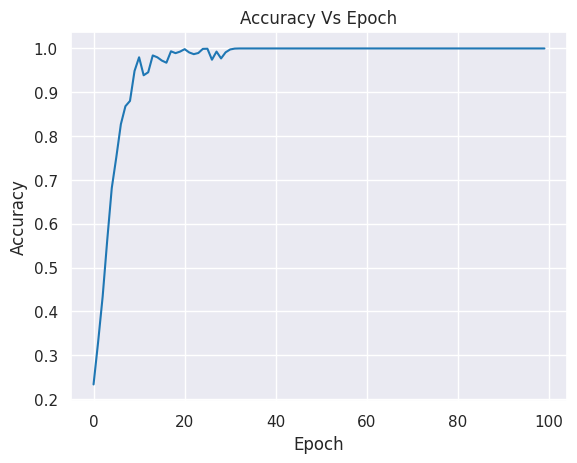

<Figure size 640x480 with 0 Axes>

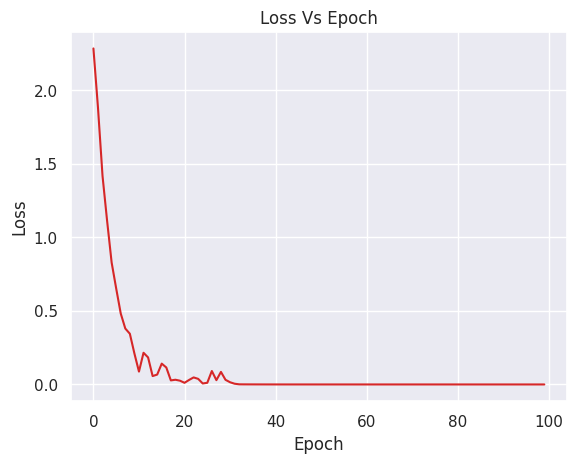

KeyError: 'train_loss'

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'],color ='tab:blue')
plt.title('Accuracy Vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Accuracy_Vs_Epoch.png',dpi=300)

plt.figure()
plt.plot(history.history['loss'],color ='tab:red')
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Loss_Vs_Epoch.png',dpi=300)

# **Testing & Confusion matrix**

225/225 - 2s - loss: 0.0894 - accuracy: 0.9921 - 2s/epoch - 7ms/step
225/225 [==============================] - 1s 6ms/step
(7175,) (7175, 16) (7175,)


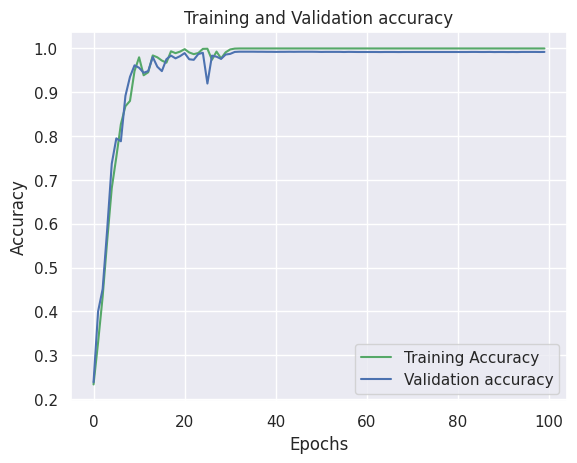

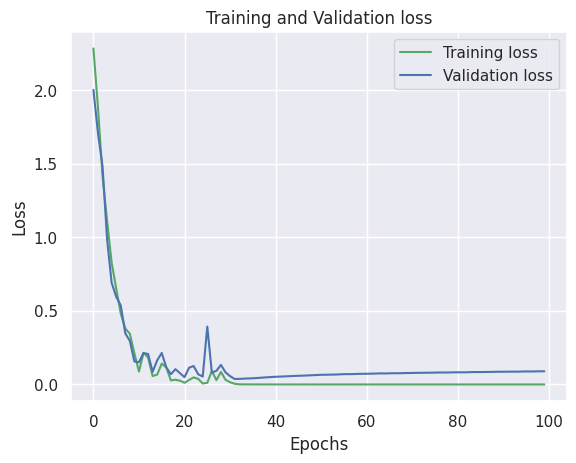

                              precision    recall  f1-score   support

                     Alfalfa       0.82      0.94      0.88        35
                 Corn-notill       0.99      1.00      0.99       992
                Corn-mintill       1.00      0.98      0.99       564
                        Corn       1.00      0.98      0.99       163
               Grass-pasture       0.98      0.97      0.97       333
                 Grass-trees       1.00      1.00      1.00       510
         Grass-pasture-mowed       0.89      0.76      0.82        21
               Hay-windrowed       1.00      1.00      1.00       343
                        Oats       0.75      1.00      0.86        12
              Soybean-notill       0.99      0.99      0.99       679
             Soybean-mintill       1.00      1.00      1.00      1712
               Soybean-clean       0.98      0.99      0.98       425
                       Wheat       0.98      0.98      0.98       146
                   

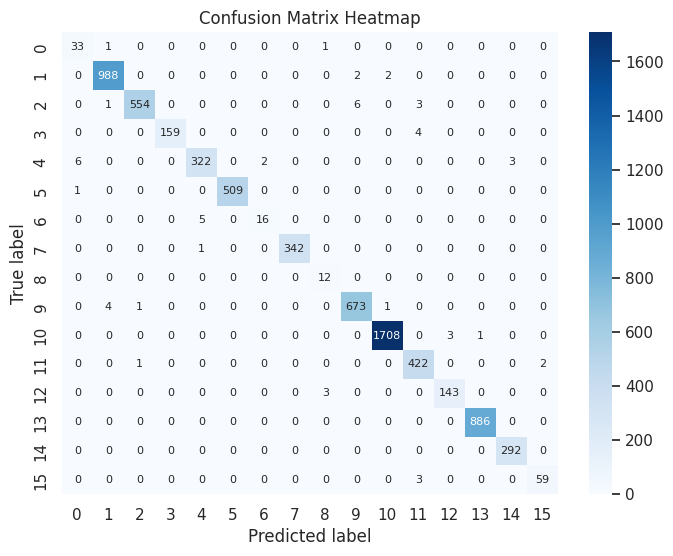

<Figure size 640x480 with 0 Axes>

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
print(y_test.shape,y_pred.shape,y_pred_classes.shape)



#Traning and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
#epochs = range(1,35)
plt.plot(loss_train, 'g', label='Training Accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Traning and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = range(1,35)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Class names of Indian Pine(16 class)
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']


classification = classification_report(y_test,y_pred_classes,  target_names=target_names)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)


# Print the confusion matrix
print(classification,conf_matrix)


#Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Adjust font scale if needed
sns.heatmap(conf_matrix, cmap='Blues', annot=True, annot_kws={"size": 8}, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()
plt.savefig('Conf_matrix_heatmap.png',dpi=300)

# **Classification report shows with precision,recall,f1,suport**

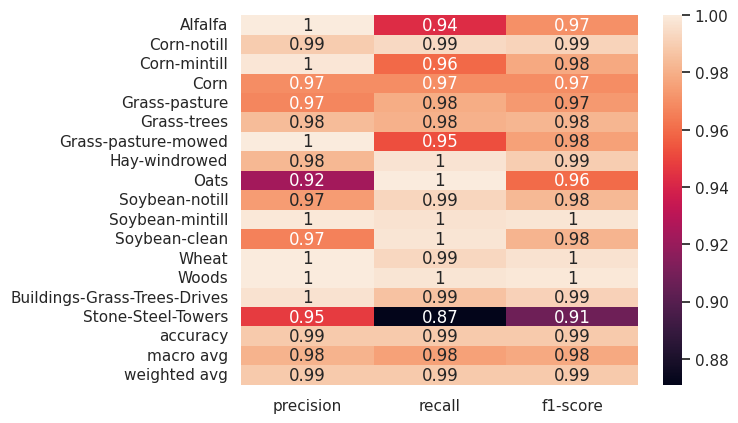

<Figure size 640x480 with 0 Axes>

In [ ]:
#precision,recall,f1 score,support in graph
classification = classification_report(y_test,y_pred_classes,  target_names=target_names,output_dict=True)
classification_df = pd.DataFrame(classification)
sns.heatmap(pd.DataFrame(classification_df).iloc[:-1, :].T, annot=True)
plt.show()
plt.savefig('Precision_recall_f1_sup_heatmap.png',dpi=300)


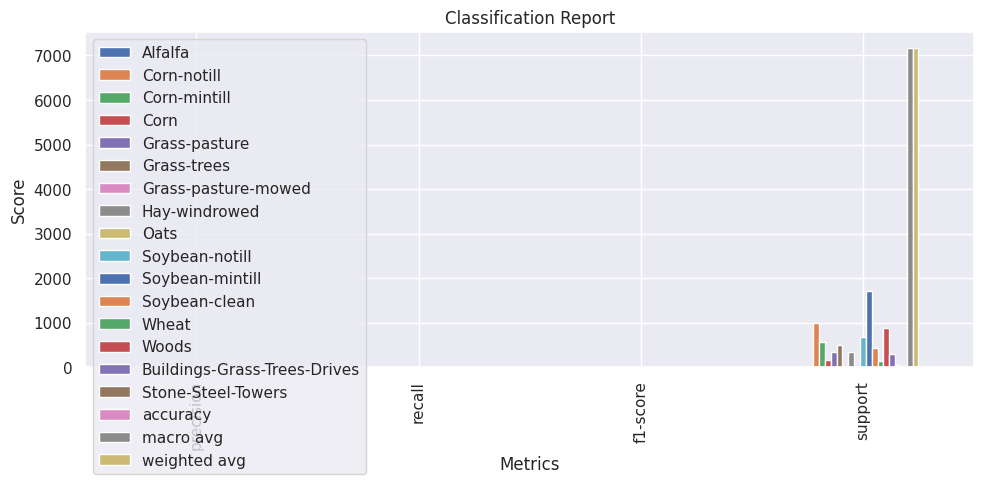

In [ ]:
# Plot the classification report
fig, ax = plt.subplots(figsize=(10, 5))
classification_df = pd.DataFrame(classification)
classification_df.plot(kind='bar', ax=ax)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Score')
# plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# **Conf_matrix heatmap with Class names of IP**

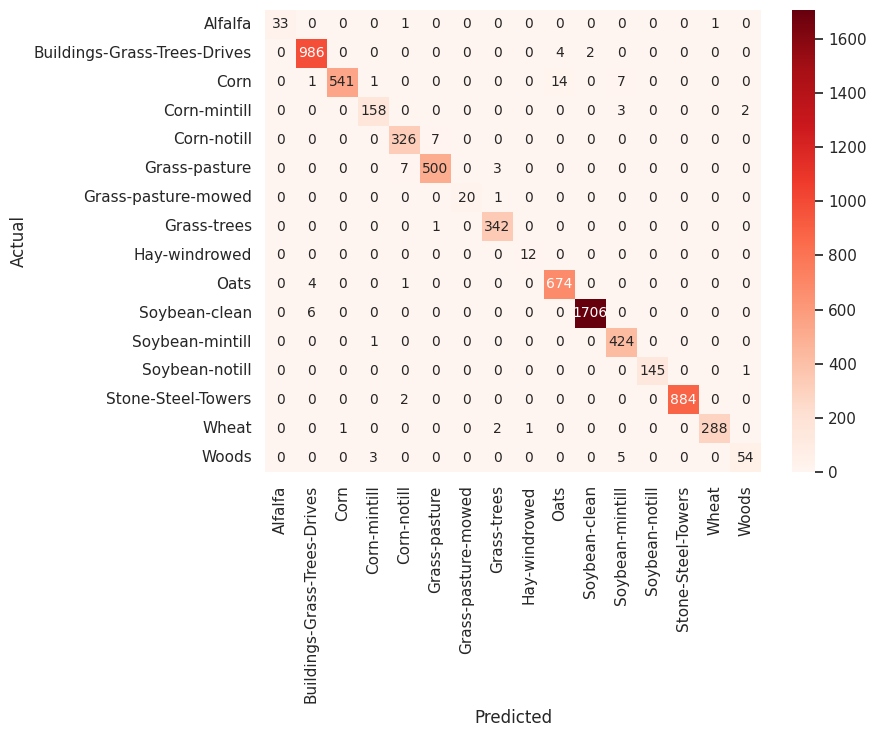

In [ ]:
classification_df = pd.DataFrame(conf_matrix, columns=np.unique(target_names), index = np.unique(target_names))
classification_df.index.name = 'Actual'
classification_df.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1)#for label size
sns.heatmap(classification_df, cmap="Reds", annot=True,annot_kws={"size": 10}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [ ]:
loss_train = history.history['train_loss']
loss_val = history.history['val_loss']
epochs = range(1,35)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

TypeError: Invalid shape (10249,) for image data

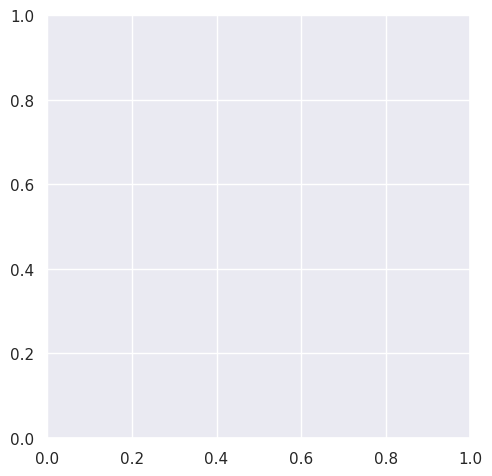

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize  # Import resize function from scikit-image

# Assuming y_true is the true ground truth (145x145) and y_pred_classes is the predicted class labels (7175 pixels)
import numpy as np
import matplotlib.pyplot as plt

# Assuming y is the true ground truth (145x145) and y_pred_classes is the predicted class labels (7175 elements)

# Assuming y is the true ground truth (145x145) and y_pred_classes is the predicted class labels (7175 elements)
import numpy as np
import matplotlib.pyplot as plt

# Assuming y is the true ground truth (145x145) and y_pred_classes is the predicted class labels (7175 elements)

# Reshape y_pred_classes into a 2D array of the same shape as y
y_pred_image = np.zeros_like(y, dtype=np.uint8)
y_pred_image_flat = y_pred_image.ravel()  # Flatten the 2D array for easier indexing
for i in range(min(len(y_pred_classes), len(y_pred_image_flat))):
    y_pred_image_flat[i] = y_pred_classes[i]

# Reshape the flattened array back to 2D
y_pred_image = y_pred_image_flat.reshape(y.shape)

# Visualize the true ground truth and the predicted ground truth
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 2)
plt.imshow(y_pred_image, cmap='viridis', interpolation='nearest')
plt.title('Predicted Ground Truth')
plt.colorbar()

plt.tight_layout()
plt.show()


# Create a color map for visualization
# Define the colors corresponding to each class in the Indian Pines dataset
# Replace these colors with the ones used in the Indian Pines dataset
class_colors = [
    [0, 0, 0],       # Class 0: Background (Black)
    [255, 0, 0],     # Class 1: Alfalfa
    [0, 255, 0],     # Class 2: Corn-notill
    [0, 0, 255],     # Class 3: Corn-min
    [255, 255, 0],   # Class 4: Corn
    [255, 0, 255],   # Class 5: Grass-pasture
    [128, 128, 128], # Class 6: Grass-trees
    [128, 0, 0],     # Class 7: Grass-pasture-mowed
    [128, 128, 0],   # Class 8: Hay-windrowed
    [0, 128, 0],     # Class 9: Oats
    [255, 255, 255], # Class 10: Soybean-notill
    [0, 255, 255],   # Class 11: Soybean-min
    [255, 255, 128], # Class 12: Soybean-clean
    [0, 0, 128],     # Class 13: Wheat
    [255, 128, 0],   # Class 14: Woods
    [0, 128, 128],   # Class 15: Buildings-Grass-Trees-Drives
]

# Create a custom color map using the defined colors
cmap = plt.cm.colors.ListedColormap(np.array(class_colors) / 255.0)


